In [1]:
# @title Phase 1: EarthShader Data Pipeline
# Description: Mounts Drive, Authenticates, and Generates the Dataset.

import os
import sys
import subprocess
import math
import shutil

# --- 1. INFRASTRUCTURE SETUP ---

# A. MOUNT GOOGLE DRIVE
from google.colab import drive, userdata
print("[SYSTEM] Mounting Google Drive...")
drive.mount('/content/drive')

# B. AUTHENTICATE HUGGING FACE
from huggingface_hub import login
from google.colab import userdata
import sys

print("\n[AUTH] Authenticating Hugging Face...")
try:
    # Try to get the token directly
    token = userdata.get('HF_TOKEN')
    login(token)
    print("   [OK] Authenticated via Token.")
except Exception:
    # If token is missing or userdata fails, just proceed anonymously
    print("   [INFO] No Token found or Auth failed. Proceeding anonymously.")

# C. INSTALL DRIVERS
print("\n[SETUP] Installing Headless EGL Drivers...")
subprocess.run(["apt-get", "update"], check=True)
subprocess.run(["apt-get", "install", "-y", "python3-opengl", "libgl1-mesa-glx", "libegl1-mesa", "libgles2-mesa-dev", "xvfb"], check=True)
subprocess.run(["pip", "install", "moderngl", "pillow", "datasets", "tqdm"], check=True)

import moderngl
import numpy as np
from PIL import Image
from datasets import load_dataset
from tqdm import tqdm

# --- 2. PIPELINE CONFIGURATION ---
CONFIG = {
    "output_dir": "/content/drive/My Drive/projects/EarthShader/dataset",
    "dataset_id": "Vipitis/Shadereval-inputs",
    "resolution": (512, 512),
    "render_time": 1.0,
    "min_lines": 5,
    "max_lines": 500,
    "min_entropy": 5.0,
    "max_samples": 1000,
}

# GLSL Wrappers
FRAGMENT_HEADER = """
#version 330
uniform vec2 iResolution;
uniform float iTime;
out vec4 fragColor;
"""
FRAGMENT_FOOTER = """
void main() {
    mainImage(fragColor, gl_FragCoord.xy);
}
"""
VERTEX_SHADER = """
#version 330
in vec2 in_vert;
void main() {
    gl_Position = vec4(in_vert, 0.0, 1.0);
}
"""

# --- 3. ENGINE LOGIC ---
def create_headless_context():
    try:
        return moderngl.create_context(standalone=True, backend='egl')
    except:
        return moderngl.create_context(standalone=True)

def calculate_visual_entropy(image):
    histogram = image.histogram()
    histogram_length = sum(histogram)
    samples_probability = [float(h) / histogram_length for h in histogram]
    return -sum([p * math.log(p, 2) for p in samples_probability if p != 0])

def render_shader(ctx, glsl_body, output_path):
    full_source = f"{FRAGMENT_HEADER}\n{glsl_body}\n{FRAGMENT_FOOTER}"
    try:
        prog = ctx.program(vertex_shader=VERTEX_SHADER, fragment_shader=full_source)
        vertices = np.array([-1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1.0], dtype='f4')
        vbo = ctx.buffer(vertices)
        vao = ctx.vertex_array(prog, [(vbo, '2f', 'in_vert')])
        fbo = ctx.simple_framebuffer(CONFIG["resolution"])
        fbo.use()

        if 'iResolution' in prog: prog['iResolution'].value = CONFIG["resolution"]
        if 'iTime' in prog: prog['iTime'].value = CONFIG["render_time"]

        ctx.clear(0.0, 0.0, 0.0)
        vao.render(moderngl.TRIANGLE_STRIP)

        raw_data = fbo.read(components=3)
        img = Image.frombytes('RGB', fbo.size, raw_data)

        if calculate_visual_entropy(img) < CONFIG["min_entropy"]:
            return False

        img.save(output_path)
        fbo.release(); vao.release(); vbo.release(); prog.release()
        return True
    except Exception:
        return False

# --- 4. EXECUTION ---
def run_pipeline():
    if not os.path.exists(CONFIG["output_dir"]):
        os.makedirs(CONFIG["output_dir"], exist_ok=True)
        print(f"\n[INFO] Created Directory: {CONFIG['output_dir']}")
    else:
        print(f"\n[INFO] Found Directory: {CONFIG['output_dir']}")

    print(f"[INFO] Streaming Dataset: {CONFIG['dataset_id']}...")

    dataset = load_dataset(CONFIG["dataset_id"], split="test", streaming=True)

    ctx = create_headless_context()
    print("[INFO] Render Context Active. Starting ingestion...")

    valid_samples = 0
    pbar = tqdm(total=467, desc="Processing")

    for sample in dataset:
        code = sample.get('image_code', sample.get('image_coded', ''))

        if not code: continue

        img_path = os.path.join(CONFIG["output_dir"], f"shader_{valid_samples}.jpg")

        if render_shader(ctx, code, img_path):
            with open(os.path.join(CONFIG["output_dir"], f"shader_{valid_samples}.glsl"), "w") as f:
                f.write(code)
            valid_samples += 1
            pbar.update(1)

    print(f"\n[SUCCESS] Pipeline Complete. Saved {valid_samples} pairs.")

if __name__ == "__main__":
    run_pipeline()

[SYSTEM] Mounting Google Drive...
Mounted at /content/drive

[AUTH] Authenticating Hugging Face...
   [OK] Authenticated via Token.

[SETUP] Installing Headless EGL Drivers...

[INFO] Found Directory: /content/drive/My Drive/projects/EarthShader/dataset
[INFO] Streaming Dataset: Vipitis/Shadereval-inputs...


README.md: 0.00B [00:00, ?B/s]

[INFO] Render Context Active. Starting ingestion...


Processing:  49%|████▉     | 231/467 [01:56<01:58,  1.99it/s]


[SUCCESS] Pipeline Complete. Saved 231 pairs.


[INFO] Dataset Size: 231 samples.
[INFO] Inspecting 3 random pairs...


/tmp/ipython-input-335485735.py:68: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


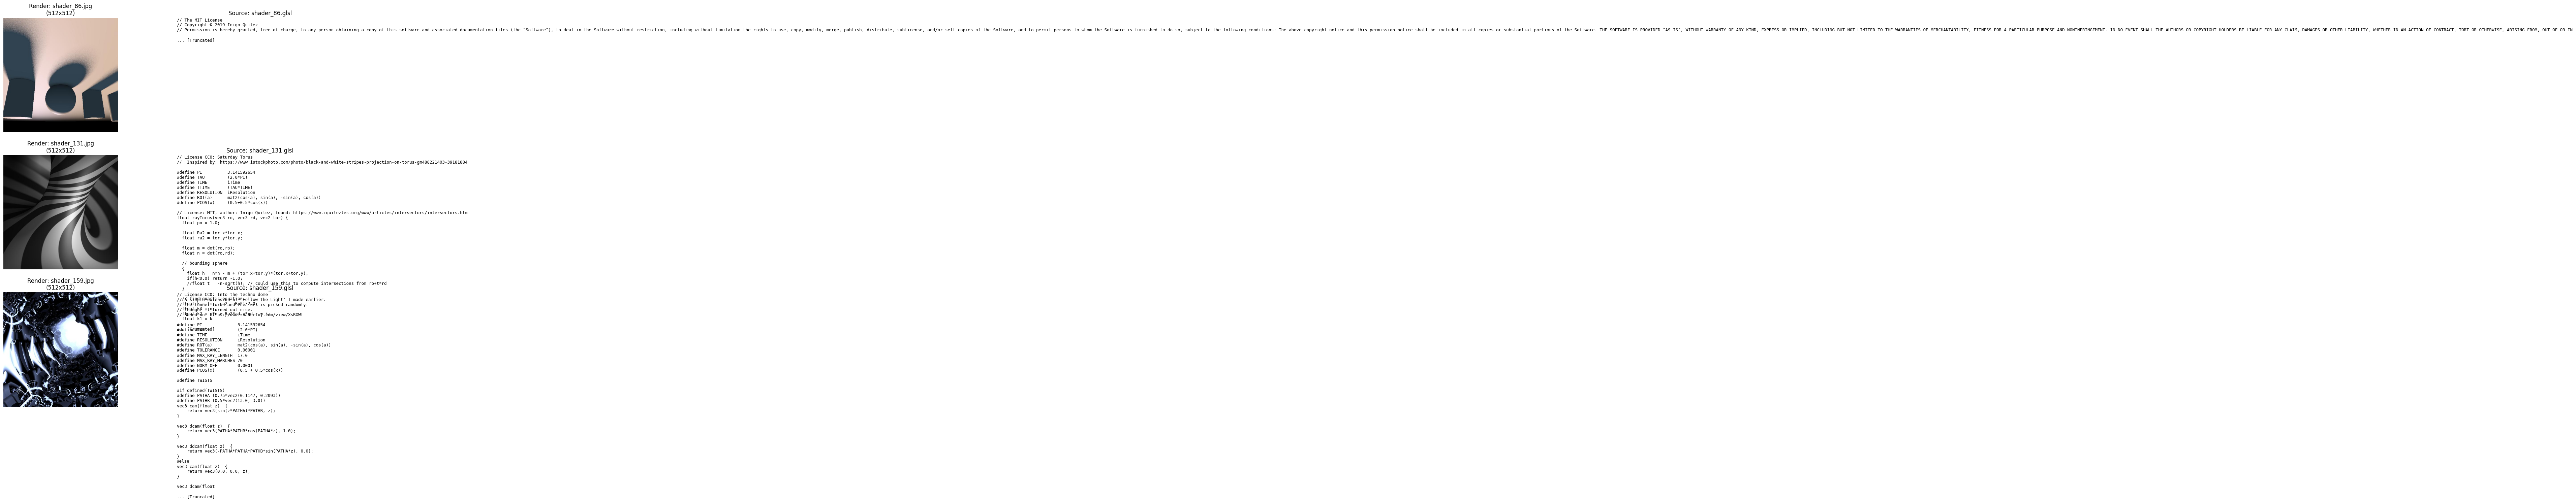

[SUCCESS] Verification complete.


In [12]:
# @title Phase 1 Verification: Data Inspection
# Description: Randomly samples generated pairs to verify alignment and quality.

import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# CONFIG: Must match the output_dir from the pipeline script
DATASET_DIR = "/content/drive/My Drive/projects/EarthShader/dataset"

def verify_data(num_samples=3):
    # 1. Integrity Check
    if not os.path.exists(DATASET_DIR):
        print(f"[ERROR] Directory not found: {DATASET_DIR}")
        print("        Ensure Google Drive is mounted.")
        return

    files = os.listdir(DATASET_DIR)
    images = [f for f in files if f.endswith(".jpg")]

    if not images:
        print("[WARN] No images found. Did the pipeline run successfully?")
        return

    print(f"[INFO] Dataset Size: {len(images)} samples.")
    print(f"[INFO] Inspecting {num_samples} random pairs...")

    # 2. Visualization
    plt.figure(figsize=(14, 5 * num_samples))

    for i in range(num_samples):
        # Pick a random sample
        img_file = random.choice(images)
        base_name = img_file.replace(".jpg", "")
        code_file = base_name + ".glsl"

        img_path = os.path.join(DATASET_DIR, img_file)
        code_path = os.path.join(DATASET_DIR, code_file)

        try:
            # Load Image
            img = Image.open(img_path)

            # Load Code
            if os.path.exists(code_path):
                with open(code_path, "r") as f:
                    code = f.read()
            else:
                code = "[ERROR] GLSL FILE MISSING"

            # Plot Left: Rendered Result
            plt.subplot(num_samples, 2, i*2 + 1)
            plt.imshow(img)
            plt.axis("off")
            plt.title(f"Render: {img_file}\n({img.size[0]}x{img.size[1]})")

            # Plot Right: Source Code (Truncated)
            plt.subplot(num_samples, 2, i*2 + 2)
            plt.text(0, 1, code[:1000] + "\n\n... [Truncated]",
                     fontsize=9, family="monospace", verticalalignment="top")
            plt.axis("off")
            plt.title(f"Source: {code_file}")

        except Exception as e:
            print(f"[ERROR] Failed to read sample {base_name}: {e}")

    plt.tight_layout()
    plt.show()
    print("[SUCCESS] Verification complete.")

verify_data(3)